In [1]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import datetime
import random
import tensorflow as tf
import math
import numpy as np
import os

2024-12-06 10:02:45.924027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def make_result_reproducible(seed_value):

    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    # import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    # import random
    random.seed(seed_value)

    # For numpy
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    # import tensorflow as tf
    tf.random.set_seed(seed_value)
    tf.keras.utils.set_random_seed(seed_value)


def assign_time_bin(df, aggregation_period):
    start_date = df['occ_date'].min().floor('D')  # Dataset's start date
    end_date = df['occ_date'].max().ceil('D') + timedelta(aggregation_period) # Dataset's end date
    print(end_date)
    time_bins = pd.date_range(start=start_date, end=end_date, freq=f'{aggregation_period}D')

    # Bin the timestamps
    df['time_bin'] = pd.cut(
        df['occ_date'],
        bins=time_bins,
        labels=time_bins[:-1],  # Label bins by their start date
        right=False
    )
    df['time_bin'] = df['time_bin'].astype('datetime64[ns]')

    print(df['time_bin'].dtype)
    return df

def prepare_data(crime_df, grid_df, aggregation_period):
    relevant_columns = ['occ_date', 'x_coordinate', 'y_coordinate']
    crime_df = crime_df[relevant_columns]

    crime_df = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df.x_coordinate, crime_df.y_coordinate))
    crime_df.set_crs('EPSG:2913', inplace=True)

    grid_crime_df = gpd.sjoin(crime_df, grid_df, how='left', predicate='within')
    grid_crime_df.dropna(inplace=True) # drop those crimes that don't fall within any grids inside the city boundry

    grid_crime_df.drop('index_right', axis=1, inplace=True)

    grid_crime_df['occ_date'] = pd.to_datetime(grid_crime_df['occ_date'])  # Ensure time is datetime
    grid_crime_df['hotspot'] = grid_crime_df['hotspot'].astype('int64')  
    grid_crime_df['unique_id'] = grid_crime_df['unique_id'].astype('int64') 

    # Aggregate crime counts over 14 days period
    # grid_crime_df['time_bin'] = grid_crime_df['occ_date'].dt.floor(f'{aggregation_period}D') # doesn't allow for custom bins
    grid_crime_df = assign_time_bin(grid_crime_df, aggregation_period)

    grid_crime_df.drop(columns=['x_index','y_index'],axis=1, inplace =True)

    crime_counts_df = grid_crime_df.groupby(['unique_id', 'time_bin']).size().reset_index(name='crime_count')

    return crime_counts_df

def fill_in_hotspots(crime_counts_df,  hotspot_cells, threshold):
    
    # hotspot_cells = crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= 5)})

    # hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index

    potential_hotspots_crime_counts_df = crime_counts_df[crime_counts_df['unique_id'].isin(hotspot_cells)]
    potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
    potential_hotspots_crime_counts_df.loc[ potential_hotspots_crime_counts_df['crime_count'] >= threshold , 'hotspot'] = 1

    return potential_hotspots_crime_counts_df

def create_sequences(df, seq_length):
    sequences = []
    for cell_id in df['unique_id'].unique():
        cell_data = df[df['unique_id'] == cell_id].sort_values('time_bin')
        for i in range(len(cell_data) - seq_length ):
            sequence = cell_data.iloc[i: i + seq_length + 1]
            sequences.append(sequence)
    return sequences




In [5]:

current_dir = os.getcwd()
train_base_dir = os.path.join(current_dir, "Data", "train")
test_base_dir = os.path.join(current_dir, "Data", "test")
cell_size = 600
aggregation_period = 14 # In days
seed_value = 1
# make_result_reproducible(seed_value)

train_crime_df = pd.read_csv(os.path.join(train_base_dir,'combined_train_data.csv'))
test_crime_df = pd.read_csv(os.path.join(test_base_dir,'test_data.csv'))

train_crime_df['occ_date'] = pd.to_datetime(train_crime_df['occ_date'])
# train_crime_df = train_crime_df[train_crime_df.occ_date.dt.date >= datetime.date(2012,3,7)] # for perfect alignment of days till feb 28
grid_df = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

train_crime_counts_df = prepare_data(train_crime_df, grid_df, aggregation_period)
test_crime_counts_df = prepare_data(test_crime_df, grid_df, aggregation_period)

# Using top 2% of the crime-counts as threshold for identifying hotspot
threshold = train_crime_counts_df.crime_count.quantile(0.98)
print(threshold)

hotspot_cells = train_crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= threshold)})

hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index


train_hotspots_crime_counts_df = fill_in_hotspots(train_crime_counts_df, hotspot_cells, threshold)
test_hotspots_crime_counts_df = fill_in_hotspots(test_crime_counts_df, hotspot_cells, threshold)


sequence_length = 26 # looking over whole year data to capture seasonal trend


2017-03-14 00:00:00
datetime64[ns]
2017-06-14 00:00:00
datetime64[ns]
5.0


/tmp/ipykernel_11103/679699447.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
/tmp/ipykernel_11103/679699447.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0


In [6]:
# run only once
last_time_bin = train_hotspots_crime_counts_df.time_bin.max()
start_time_bin_test_data_dependends_upon = last_time_bin - timedelta(aggregation_period*(sequence_length-1))
historical_data_for_test_df = train_hotspots_crime_counts_df[train_hotspots_crime_counts_df.time_bin >= start_time_bin_test_data_dependends_upon ]
test_hotspots_crime_counts_df = pd.concat([historical_data_for_test_df, test_hotspots_crime_counts_df])



In [7]:
train_time_bins = pd.date_range(train_crime_counts_df.time_bin.min(), train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_history = pd.date_range(start_time_bin_test_data_dependends_upon, train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_current = pd.date_range(test_crime_counts_df.time_bin.min(), test_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins = test_time_bins_history.append(test_time_bins_current)

In [8]:
# Create every possible hotspot_cell-time_bin combination
grid_time_bin_train_df = pd.DataFrame([(grid, time_bin) for grid in hotspot_cells for time_bin in train_time_bins],columns=['unique_id', 'time_bin'])
grid_time_bin_test_df = pd.DataFrame([(grid, time_bin) for grid in hotspot_cells for time_bin in test_time_bins.sort_values()],columns=['unique_id', 'time_bin'])


In [9]:
# run only once
train_hotspots_crime_counts_df = grid_time_bin_train_df.merge(train_hotspots_crime_counts_df, on=['unique_id', 'time_bin'], how='left').fillna(0)
test_hotspots_crime_counts_df = grid_time_bin_test_df.merge(test_hotspots_crime_counts_df, on=['unique_id', 'time_bin'], how='left').fillna(0)

In [10]:
train_hotspots_crime_counts_df['hotspot'] = train_hotspots_crime_counts_df['hotspot'].astype(int)
test_hotspots_crime_counts_df['hotspot'] = test_hotspots_crime_counts_df['hotspot'].astype(int)

In [11]:

train_hotspots_crime_counts_df = train_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])
test_hotspots_crime_counts_df = test_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])

In [12]:
training_sequences = create_sequences(train_hotspots_crime_counts_df, seq_length=sequence_length)


In [13]:
# training_sequences[0]

In [14]:
testing_sequences = create_sequences(test_hotspots_crime_counts_df, seq_length=sequence_length)

In [15]:
# testing_sequences[0]

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

positive_data = []
negative_data = []
for sequence in training_sequences:
    if sequence['hotspot'].iloc[-1] == 1:
        positive_data.append(sequence)
    else:
        negative_data.append(sequence)

print(len(positive_data))
negative_sample = resample(negative_data, replace=False,  n_samples=len(positive_data), random_state=seed_value) 

balanced_data = positive_data + negative_sample



train_data, val_data = train_test_split(balanced_data, test_size=0.1, random_state=seed_value)

test_data = testing_sequences
# # Split the remaining set into validation and test sets
# val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=1)

2248


In [17]:
def prepare_trainable_data(samples):
    X = []
    y = []
    for seq in samples:
        X_seq = seq[['crime_count']].values  # Select features for X
        X.append(X_seq[:-1])  # Exclude the last time step from X
        y.append(seq['hotspot'].iloc[-1])  # Use the last time step's 'hotspot' value as y
    # return X, y
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = prepare_trainable_data(train_data)

# Prepare validation data
X_val, y_val = prepare_trainable_data(val_data)

# Prepare test data
X_test, y_test = prepare_trainable_data(test_data)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4046, 26, 1), (2457, 26, 1), (4046,), (2457,))

In [32]:
make_result_reproducible(seed_value)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=20, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate= 0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 


In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, )

history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4844 - loss: 0.7828 - val_accuracy: 0.5622 - val_loss: 0.7278
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5002 - loss: 0.7456 - val_accuracy: 0.5622 - val_loss: 0.7038
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5389 - loss: 0.7156 - val_accuracy: 0.5622 - val_loss: 0.6805
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6071 - loss: 0.6824 - val_accuracy: 0.7800 - val_loss: 0.6573
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7089 - loss: 0.6537 - val_accuracy: 0.8067 - val_loss: 0.6349
Epoch 6/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7673 - loss: 0.6268 - val_accuracy: 0.8089 - val_loss: 0.6097
Epoch 7/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7815 - loss: 0.6010 - val_accuracy: 0.8111 - val_loss: 0.5784
Epoch 8/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8083 - loss: 0.5658 - val_accuracy: 0.8156 - v

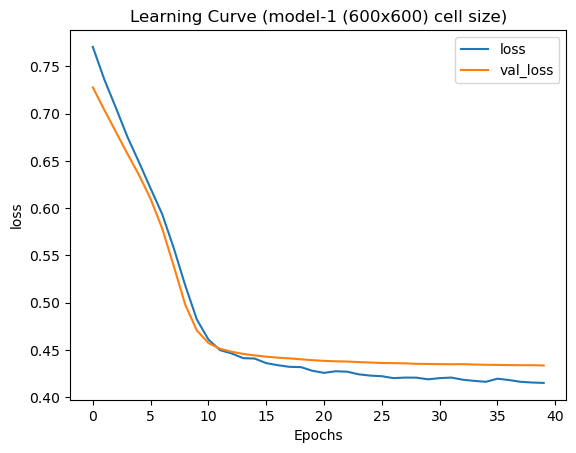

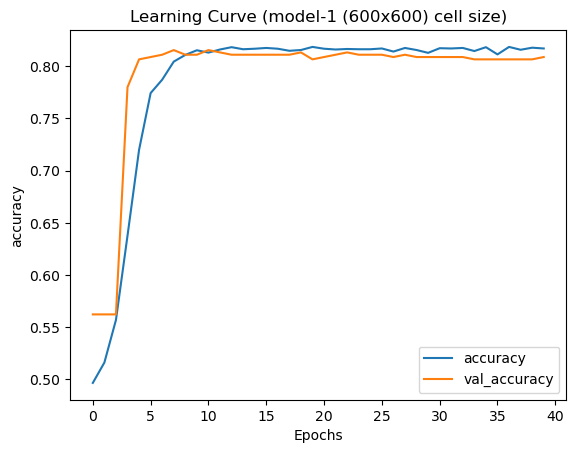

In [34]:
import matplotlib.pyplot as plt

model_name = 'model-2' if cell_size == 250 else 'model-1'

def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.title(f'Learning Curve ({model_name} ({cell_size}x{cell_size}) cell size)')
  plt.show()
# Plot the history
plot_history(history, 'loss')
plot_history(history, 'accuracy')

# plot_history(history, 'precision')
# plot_history(history, 'recall')


In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Evaluate the model on the val data
# _, accuracy = model.evaluate(X_val, y_val)
loss, accuracy = model.evaluate(X_val, y_val)
print('Accuracy: %.2f' % (accuracy*100))
# print(metrics)
# Make predictions on the val data
y_pred = model.predict(X_val)
y_pred_binary = (y_pred >= 0.5).astype(int)  # Convert probabilities to binary predictions   


# Calculate additional metrics
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val,  y_pred_binary)

print('Precision: %.2f' % (precision*100))
print('Recall: %.2f' % (recall*100))
print('F1-score: %.2f' % (f1*100))

confusion_matrix(y_val, y_pred_binary)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7984 - loss: 0.4311
Accuracy: 80.89
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: 82.08
Recall: 72.08
F1-score: 76.76


array([[222,  31],
       [ 55, 142]])

In [95]:
# Test the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))
# Make predictions on the test data
y_pred = model.predict(X_test)

y_pred_binary = (y_pred >= 0.5).astype(int)  # Convert probabilities to binary predictions   


# Calculate additional metrics
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test,  y_pred_binary)

print('Precision: %.2f' % (precision*100))
print('Recall: %.2f' % (recall*100))
print('F1-score: %.2f' % (f1*100))

confusion_matrix(y_test, y_pred_binary)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8582 - loss: 0.3628
Accuracy: 87.06
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 30.53
Recall: 81.41
F1-score: 44.41


array([[2012,  289],
       [  29,  127]])

In [131]:
# # history l1= 50, l2 = 20

# 77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8468 - loss: 0.3697
# Accuracy: 85.92
# 77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
# Precision: 73.87
# Recall: 52.56
# F1-score: 61.42


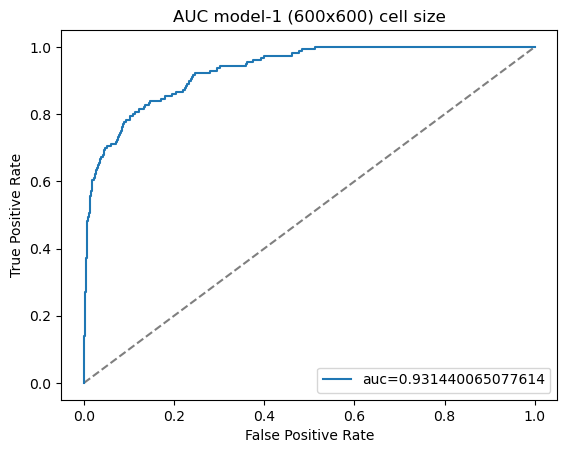

In [38]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.title(f'AUC {model_name} ({cell_size}x{cell_size}) cell size')
plt.show()

In [86]:
import datetime
crime_hotspots = test_hotspots_crime_counts_df[test_hotspots_crime_counts_df.time_bin.dt.date >= datetime.date(2017, 3, 1) ]

crime_hotspots.loc[:,'predicted'] = y_pred_binary
# crime_hotspots.to_csv(f'forecasted_result_{cell_size}_threshold_0.5.csv')
y_pred_binary.sum()

confusion_matrix(crime_hotspots.hotspot, crime_hotspots.predicted)

/tmp/ipykernel_11103/1232332473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_hotspots.loc[:,'predicted'] = y_pred_binary


array([[2272,   29],
       [  77,   79]])

In [46]:

grid = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

In [87]:
test_time_step_starting_dates = test_time_bins[-7:]
crime_hotspots_1st_week = crime_hotspots[crime_hotspots.time_bin.dt.date == test_time_step_starting_dates[0].date() ]

predicted_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].unique_id)
hotspot_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['hotspot'] == 1].unique_id)

total_crimes_in_predicted_hotspots = crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].crime_count.sum()
total_crimes = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date == test_time_step_starting_dates[0].date()].crime_count.sum()

predicted_hotspots_area = grid[grid.unique_id.isin(predicted_grid_ids)].area.sum()
total_area = grid.area.sum()
print(predicted_grid_ids)
hotspot_grid_ids
# # # x

[4460 4576 5042 5043 5044 5156 5157 5270 5271]


array([ 4460,  4576,  4580,  4924,  5040,  5041,  5042,  5043,  5044,
        5156,  5157,  5158,  5270,  5271,  5969,  6074,  6172,  7163,
        7176,  8765,  9404,  9502, 10154, 10156, 11516])

In [48]:

print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)


pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
print(f"PAI = {pai}")
# pai


221.0
1381
18325351.73948967
4117743414.8055296
PAI = 35.95883037835799


In [375]:

test_crime_count_list = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date == test_time_step_starting_dates[0].date()].crime_count
desc_sorted = -np.sort(-np.array(test_crime_count_list))
number_of_cells =  math.ceil(predicted_hotspots_area/ (cell_size**2)) # Rough estimation that each cell is of size cell_size_sq
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted[:number_of_cells].sum()

pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)

print(number_of_cells)
print(total_crimes_in_predicted_hotspots)
print(maximum_obtainable_crimes_for_the_forecasted_area)
print(f"PEI: {pei}")

# grid['pre']
    
# # y_test
# test_crime_counts_df.crime_count.max()

226
270.0
501
PEI: 0.5389221556886228


In [376]:
len(predicted_grid_ids), len(hotspot_grid_ids), len(np.intersect1d(predicted_grid_ids, hotspot_grid_ids))

(226, 48, 36)

In [ ]:
grid.loc[grid.unique_id.isin(predicted_grid_ids), 'hotspot'] = 1
grid.loc[grid.unique_id.isin(hotspot_grid_ids), 'hotspot'] = 2
grid.loc[grid.unique_id.isin(np.intersect1d(predicted_grid_ids, hotspot_grid_ids)), 'hotspot'] = 3
grid.to_file(f"visualizations/{cell_size}/shape-files/crime-forecast-grid-mar-01-mar-14-threshold-0.9.shp")


### For 3 month period

In [109]:


all_predicted_hotspot_cell_ids =  crime_hotspots[crime_hotspots.predicted == 1].unique_id.unique()
all_hotspot_cell_ids =  crime_hotspots[crime_hotspots.hotspot == 1].unique_id.unique()
all_hotspot_cells =  crime_hotspots.groupby('unique_id').agg({'hotspot': lambda x: np.any(x == 1)}).astype(int)
all_hotspot_cell_ids2 = all_hotspot_cells.loc[all_hotspot_cells.hotspot == 1].index

total_crimes_in_predicted_hotspots = crime_hotspots[crime_hotspots['predicted'] == 1].crime_count.sum()
total_crimes = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date >= test_time_step_starting_dates[0].date()].crime_count.sum()

predicted_hotspots_area = grid[grid.unique_id.isin(all_predicted_hotspot_cell_ids)].area.sum()
total_area = grid.area.sum()

# print(np.intersect1d(all_hotspot_cell_ids, all_predicted_hotspot_cell_ids))
# print(all_predicted_hotspot_cell_ids)
all_hotspot_cell_ids.size
print(all_hotspot_cell_ids)
print(all_hotspot_cell_ids2)



[ 1522  4013  4348  4349  4460  4575  4576  4577  4580  4692  4693  4809
  4811  4814  4815  4924  4926  4927  5038  5040  5041  5042  5043  5044
  5046  5153  5155  5156  5157  5158  5160  5269  5270  5271  5676  5774
  5776  5967  5969  6074  6172  7079  7163  7176  8557  8575  8653  8765
  8768  9071  9404  9502 10069 10154 10155 10156 10508 11440 11441 11516
 11517 11781]
Index([ 1522,  4013,  4348,  4349,  4460,  4575,  4576,  4577,  4580,  4692,
        4693,  4809,  4811,  4814,  4815,  4924,  4926,  4927,  5038,  5040,
        5041,  5042,  5043,  5044,  5046,  5153,  5155,  5156,  5157,  5158,
        5160,  5269,  5270,  5271,  5676,  5774,  5776,  5967,  5969,  6074,
        6172,  7079,  7163,  7176,  8557,  8575,  8653,  8765,  8768,  9071,
        9404,  9502, 10069, 10154, 10155, 10156, 10508, 11440, 11441, 11516,
       11517, 11781],
      dtype='int64', name='unique_id')


In [379]:

print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)

pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
print(f"PAI = {pai}")


1926.0
9553
22915275.19749321
4117743414.806666
PAI = 36.22852971647746


In [380]:
# 763.0
# 9553
# 7165351.739489673
# 4117743414.8055296
# PAI = 45.89934914111569

In [381]:


desc_sorted_test_crime_count_list = test_crime_counts_df.groupby('unique_id').agg({'crime_count': lambda x: sum(x)}).crime_count.sort_values(ascending=False)
number_of_cells =  math.ceil(predicted_hotspots_area/ (cell_size**2)) # Rough estimation that each cell is of size cell_size_sq
# print(number_of_cells)
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted_test_crime_count_list[:number_of_cells].sum()
# print(desc_sorted)
pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)
print(f"PEI: {pei}")
print(total_crimes_in_predicted_hotspots)
print(maximum_obtainable_crimes_for_the_forecasted_area)



PEI: 0.6800847457627118
1926.0
2832


In [296]:
grid.loc[grid.unique_id.isin(all_predicted_hotspot_cell_ids), 'hotspot'] = 1
grid.loc[grid.unique_id.isin(all_hotspot_cell_ids), 'hotspot'] = 2
grid.loc[grid.unique_id.isin(np.intersect1d(all_predicted_hotspot_cell_ids, all_hotspot_cell_ids)), 'hotspot'] = 3
grid.to_file(f"visualizations/{cell_size}/shape-files/crime-forecast-grid-mar-01-may-31-threshold-0.9.shp")

# OLD extra


In [ ]:
# import numpy as np
# from sklearn.model_selection import GridSearchCV
# # from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# # from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# # from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam


# # Define the LSTM model
# def create_model(units=50, learning_rate=0.001):
#     model = Sequential()
#     model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(LSTM(units=units))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
#     return model

# # Create a KerasClassifier
# model = KerasClassifier(build_fn=create_model)

# # Define the hyperparameter grid
# param_grid = {
#     'model__units': [20, 50, 80],
#     'model__learning_rate': [0.01, 0.001, 0.0001],
#     'batch_size': [16, 32, 64],
#     'epochs': [20, 30, 40]
# }

# # Create a GridSearchCV object
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)  # 3-fold cross-validation

# # Fit the grid search to the data
# grid_result = grid.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
# ## Grid Search

# # import os
# # os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# import numpy as np
# from sklearn.model_selection import GridSearchCV
# # from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam


# # Define the LSTM model
# def create_model(units_layer1=50,units_layer2=50, learning_rate=0.001):
#     model = Sequential()
#     model.add(LSTM(units=units_layer1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(LSTM(units=units_layer2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
#     return model

# # Create a KerasClassifier
# model = KerasClassifier(build_fn=create_model, metrics=['accuracy'],verbose=0)

# # Define the hyperparameter grid
# # param_grid = {
# #     'model__units': [20, 50, 80],
# #     'model__learning_rate': [0.01, 0.001, 0.0001],
# #     'batch_size': [16, 32, 64],
# #     'epochs': [20, 30, 40]
# # }

# param_grid = {
#     'model__units': [20,50,80],
#     'model__learning_rate': [0.001, 0.0001],
#     'batch_size': [32, 64],
#     'epochs': [20, 50]
# }
# param_grid = {
#     'model__units_layer1': [50,100],
#     'model__units_layer2': [25,50],
#     'model__learning_rate': [0.001, 0.0001],
#     'batch_size': [32],
#     'epochs': [50]
# }

# model = KerasClassifier(model=create_model, optimizer='adam', verbose=0)

# # Fit and predict
# # model.fit(X_train, y_train)
# # predictions = model.predict(X_test)


# # # Create a GridSearchCV object
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, error_score='raise')  # 3-fold cross-validation

# # Fit the grid search to the data
# grid_result = grid.fit(X_train, y_train)

# # Print the best hyperparameters
# print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")